### Results only shown for 1 network, simply change the model used to try other architectures

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import numpy as np
import numpy.matlib
import math
import random
import timit_utils as tu
import timit_utils.audio_utils as au
import timit_utils.drawing_utils as du

corpus = tu.Corpus('TIMIT')
train = corpus.train
test = corpus.test
corpus.train, corpus.test

(<timit_utils.core.SubCorpus at 0x19471c98c08>,
 <timit_utils.core.SubCorpus at 0x19471e80a88>)

### Check for length of sentences.

In [2]:
sentence_lengths = []
for p in range(len(train.people)):
    for s in range(len(train.person_by_index(p).sentences)):
        sentence = train.person_by_index(p).sentence_by_index(s).raw_audio
        sentence_lengths.append(len(sentence))
print('Max sentence length in training set is ', max(sentence_lengths)/16000, ' seconds.')
print('Min sentence length in training set is ', min(sentence_lengths)/16000, ' seconds.')
#plt.hist([x / 16000 for x in sentence_lengths], bins=100)
#plt.title('Histogram of Training Sentence Lengths')
#plt.xlabel('Length [sec]')
#plt.ylabel('Number of Sentences')
#plt.show()

Max sentence length in training set is  7.7888125  seconds.
Min sentence length in training set is  0.91525  seconds.


In [3]:
sentence_lengths = []
for p in range(len(test.people)):
    for s in range(len(test.person_by_index(p).sentences)):
        sentence = test.person_by_index(p).sentence_by_index(s).raw_audio
        sentence_lengths.append(len(sentence))
print('Max sentence length in testing set is ', max(sentence_lengths)/16000, ' seconds.')
print('Min sentence length in testing set is ', min(sentence_lengths)/16000, ' seconds.')
#plt.hist([x / 16000 for x in sentence_lengths], bins=100)
#plt.title('Histogram of Testing Sentence Lengths')
#plt.xlabel('Length [sec]')
#plt.ylabel('Number of Sentences')
#plt.show()

Max sentence length in testing set is  7.57125  seconds.
Min sentence length in testing set is  1.0944375  seconds.


### Make all training and testing samples the same length in time.

In [4]:
data_set = []
label_id = []
for p in range(len(train.people)):
    count = 0
    for s in range(len(train.person_by_index(p).sentences)):
        sentence = train.person_by_index(p).sentence_by_index(s).raw_audio
        data_set.append(sentence)
        label_id.append(train.person_by_index(p).name)
for p in range(len(test.people)):
    count = 0
    for s in range(len(test.person_by_index(p).sentences)):
        sentence = test.person_by_index(p).sentence_by_index(s).raw_audio
        data_set.append(sentence)
        label_id.append(test.person_by_index(p).name)
num_speakers = len(set(label_id))
print('Number of speakers in data: ', num_speakers)

Number of speakers in data:  630


In [5]:
num_speakers = 20 # number of speakers being considered
le1 = preprocessing.LabelEncoder()
le1.fit(label_id)
label_id = le1.transform(label_id)

sub_data_set = []
sub_label_id = []
speak_ind = []
for ind1 in range(num_speakers):
    ind2 = np.random.randint(630, size=1)
    while ind2[0] in speak_ind is False:
        ind2 = np.random.randint(630, size=1)
    speak_ind.append(ind2[0])
act_ind = []
for ID in speak_ind:
    act_ind= np.where(label_id == ID)
    sub_data_set = sub_data_set+data_set[act_ind[0][0]:act_ind[0][-1]+1]
    sub_label_id = sub_label_id+label_id[act_ind[0]].tolist()

In [6]:
L = 1 # length of samples in seconds
Fs = 16000

num_train_per_test = 3 # for every 3 training sentences, there is 1 testing sentence
training_set = []
training_label_id = []
testing_set = []
testing_label_id = []
for ID in set(sub_label_id):
    person_ind = [i for i, x in enumerate(sub_label_id) if x == ID]
    for i, sent_per_ID in enumerate(person_ind):
        if i%(num_train_per_test+1) == 0:
            testing_set.append(sub_data_set[sent_per_ID])
            testing_label_id.append(sub_label_id[sent_per_ID])
        else:
            training_set.append(sub_data_set[sent_per_ID])
            training_label_id.append(sub_label_id[sent_per_ID])

ave_seconds_per_ID = sum(sentence_lengths)/(Fs*len(sentence_lengths))*10
num_samps_per_ID = round(ave_seconds_per_ID)*10
num_samps_per_ID_test = round(num_samps_per_ID*(1/(num_train_per_test+1)))
num_samps_per_ID_train = num_samps_per_ID-num_samps_per_ID_test
train_set = []
train_l = []
test_set = []
test_l = []
for ID_i, ID in enumerate(set(sub_label_id)):
    train_person_ind = [i for i, x in enumerate(training_label_id) if x == ID]
    test_person_ind = [i for i, x in enumerate(testing_label_id) if x == ID]
    for samp in range(num_samps_per_ID_train):
        sent = random.choice(train_person_ind)
        while len(training_set[sent]) < round(Fs*L):
            sent = random.choice(train_person_ind)
        start_i = random.randint(0,len(t0.999raining_set[sent])-round(Fs*L))
        train_set.append(training_set[sent][start_i:start_i+round(Fs*L)])
        train_l.append(ID_i)
    for samp in range(num_samps_per_ID_test):
        sent = random.choice(test_person_ind)
        while len(testing_set[sent]) < round(Fs*L):
            sent = random.choice(test_person_ind)
        start_i = random.randint(0,len(testing_set[sent])-round(Fs*L))
        test_set.append(testing_set[sent][start_i:start_i+round(Fs*L)])
        test_l.append(ID_i)

In [ ]:
#Scale training data
train_max=np.array([np.max(train_set,1)]).T
train_max=np.matlib.repmat(train_max,1,np.shape(train_set)[1])
train_set=np.divide(train_set,train_max)
#train_set=train_set[0:1000]

test_max=np.array([np.max(test_set,1)]).T
test_max=np.matlib.repmat(test_max,1,np.shape(test_set)[1])
test_set=np.divide(test_set,test_max)
#test_set=test_set[0:500]

In [7]:
print(np.shape(train_set))
print(np.shape(train_l))
print(np.shape(test_set))
print(np.shape(test_l))

(4408, 16000)
(4408,)
(1482, 16000)
(1482,)


In [8]:
freq_norm=1

pow2=math.ceil(math.log(round(16000*L),2))
NFFT=2**14

max_freq=2000

freqs=np.fft.fftfreq(NFFT,1/Fs)
mag_train_set=np.abs(np.fft.fft(train_set,NFFT,1))
mag_test_set=np.abs(np.fft.fft(test_set,NFFT,1))

phase_train_set=np.angle(np.fft.fft(train_set,NFFT,1))
phase_test_set=np.angle(np.fft.fft(test_set,NFFT,1))

idx_freq=np.where(freqs>=max_freq)[0][0]+1
mag_train_set=mag_train_set[:,0:idx_freq]
mag_test_set=mag_test_set[:,0:idx_freq]

phase_train_set=phase_train_set[:,0:idx_freq]
phase_test_set=phase_test_set[:,0:idx_freq]

if freq_norm==1:
    freq_train_max=np.array([np.max(mag_train_set,1)]).T
    freq_train_max=np.matlib.repmat(freq_train_max,1,np.shape(mag_train_set)[1])
    mag_train_set=np.divide(mag_train_set,freq_train_max)

    freq_test_max=np.array([np.max(mag_test_set,1)]).T
    freq_test_max=np.matlib.repmat(freq_test_max,1,np.shape(mag_test_set)[1])
    mag_test_set=np.divide(mag_test_set,freq_test_max)

freq_train_set=mag_train_set
freq_test_set=mag_test_set
print(np.shape(freq_train_set))
print(np.shape(freq_test_set))

(4408, 2049)
(1482, 2049)


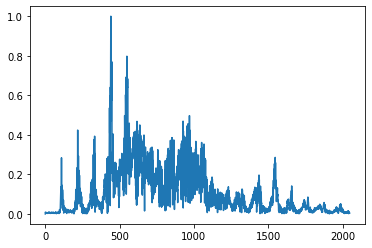

In [9]:
plt.plot(mag_test_set[0,:])

## PCA (didn't help results)

n_components=400
pca = PCA(n_components)
pca.fit(train_set)

train_set_red = pca.transform(train_set)
test_set_red = pca.transform(test_set)

plt.plot(np.arange(1,n_components+1), 100*pca.explained_variance_ratio_ , '^', lw=3, markersize = 15)
plt.xlabel('Index of Sindular Values')
plt.ylabel('Explained Variance Percentage')
plt.grid()
print(np.sum(pca.explained_variance_ratio_))

model = LogisticRegression(random_state=0, solver='saga',multi_class='multinomial',max_iter=10000).fit(freq_train_set, train_l)

train_output = model.predict(freq_train_set)
test_output = model.predict(freq_test_set)

acc_train_vec=torch.zeros((np.shape(train_set)[0],))
for i in range(np.shape(train_set)[0]):
    if train_output[i]==train_l[i]:
        acc_train_vec[i]=1

acc_test_vec=torch.zeros((np.shape(test_set)[0],))
for i in range(np.shape(test_set)[0]):
    if test_output[i]==test_l[i]:
        acc_test_vec[i]=1
        
acc_train=torch.sum(acc_train_vec)/np.shape(train_set)[0]*100
acc_test=torch.sum(acc_test_vec)/np.shape(test_set)[0]*100
print('Train Accuracy for PCA= {:.4f}%'.format(acc_train.item()))
print('Test Accuracy for PCA= {:.4f}%'.format(acc_test.item()))

### Data loaders for time-series input.

In [10]:
batch_size = 100
train_loader,test_loader = {},{}
num_speakers = len(set(train_l))
train_list = []
for ind, data in enumerate(freq_train_set):
    train_list.append((data, train_l[ind]))
test_list = []
for ind, data in enumerate(freq_test_set):
    test_list.append((data, test_l[ind]))
train_loader['timit'] = torch.utils.data.DataLoader(train_list, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader['timit'] = torch.utils.data.DataLoader(test_list, batch_size=batch_size, shuffle=False, num_workers=0)



### Construct the 1D CNN architecture.

In [ ]:
class conv_nn_1d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(conv_nn_1d, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=32, kernel_size=32, stride=1, padding=0, bias=True)
        self.bn1   = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=24, kernel_size=16, stride=1, padding=0, bias=True)
        self.bn2   = nn.BatchNorm1d(24)
        self.conv3 = nn.Conv1d(in_channels=24, out_channels=16, kernel_size=8, stride=1, padding=0, bias=True)
        self.bn3   = nn.BatchNorm1d(16)
        self.conv4 = nn.Conv1d(in_channels=16, out_channels=12, kernel_size=4, stride=1, padding=0, bias=True)
        self.bn4   = nn.BatchNorm1d(12)
        self.fc1   = nn.Linear(in_features=12*121, out_features=1000)
        self.fc2   = nn.Linear(in_features=1000,out_features=500)
        self.fc3   = nn.Linear(in_features=500,out_features=100)
        self.fc4   = nn.Linear(in_features=100,out_features=out_channels)

    def forward(self, x):
        #x = torch.tanh(self.bn1(self.conv1(x)))
        x = torch.tanh(self.conv1(x))
        x = F.max_pool1d(x,2)
        #x = torch.tanh(self.bn2(self.conv2(x)))
        x = torch.tanh(self.conv2(x))
        x = F.max_pool1d(x,2)
        #x = torch.tanh(self.bn3(self.conv3(x)))
        x = torch.tanh(self.conv3(x))
        x = F.max_pool1d(x,2)
        #x = torch.tanh(self.bn4(self.conv4(x)))
        x = torch.tanh(self.conv4(x))
        x = F.max_pool1d(x,2)
        x = x.view(x.size(0), -1) # flattens
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x),dim=1)
        return x

## Logistic Regression

In [ ]:
class timit_log_reg(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(timit_log_reg, self).__init__()
        self.fc1 = nn.Linear(in_channels, out_channels,bias=True)

    def forward(self, x):
        x=F.softmax(self.fc1(x),dim=1)
        return x

## DNN

In [11]:
class timit_dnn(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(timit_dnn, self).__init__()
        self.fc1 = nn.Linear(in_channels, 1600,bias=True)
        self.fc2 = nn.Linear(1600,400,bias=True)
        self.fc3 = nn.Linear(400,100,bias=True)
        self.fc4 = nn.Linear(100,out_channels,bias=True)

    def forward(self, x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x=F.softmax(self.fc4(x),dim=1)
        return x

In [12]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    train_loss = 0
    correct_train=0
    model.train()
    model.double()
    for batch_idx, (data, target) in enumerate(train_loader):
        #if batch_idx==0:
            #plt.figure()
            #plt.plot(data[0,:])
        data, target = data.to(device), target.to(device)
        #data = data.reshape(len(data),1,data[0].size()[0])
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target) #sometimes different criteria requires multiplying by batch size
        loss.backward()

        pred_train = output.argmax(dim=1, keepdim=True)
        correct_train += pred_train.eq(target.view_as(pred_train)).sum().item()
        train_loss += loss.item()
        train_loss=train_loss/(batch_idx+1)
        train_acc=100. * correct_train / len(train_loader.dataset)
        optimizer.step()
        #if batch_idx % (len(train_loader)//2) == 0:
            #print('Train({})[{:.0f}%]: Loss: {:.4f},Train Accuracy: {:.4f}%'.format(
                #epoch, 100. * batch_idx / len(train_loader), train_loss,train_acc))
    return train_loss,train_acc
            
def test(model, device, test_loader, criterion, epoch):
    model.eval()
    model.double()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            #data = data.reshape(len(data),1,data[0].size()[0])
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            
            #print(output)
            #print(target)
            #print(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()
            test_acc=100. * correct / len(test_loader.dataset)

    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    #print('Test({}): Loss: {:.4f},Test Accuracy: {:.4f}%'.format(
        #epoch, test_loss, test_acc))
    return test_loss,test_acc

In [13]:
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer
    
def make_scheduler(scheduler_name, optimizer, **kwargs):
    if scheduler_name=='MultiStepLR':
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=kwargs['milestones'],gamma=kwargs['factor'])
    else:
        raise ValueError('Not valid scheduler name')
    return scheduler

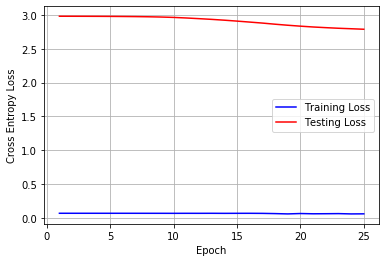

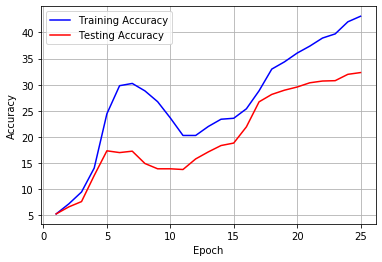

Epoch= 25
Train Acc= 43.10344827586207
Test Acc= 32.32118758434548
Optimizer Learning rate: 0.0000


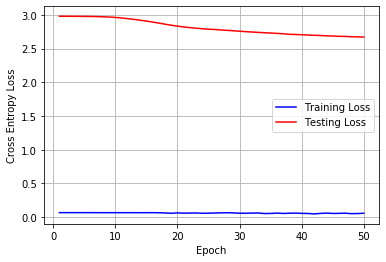

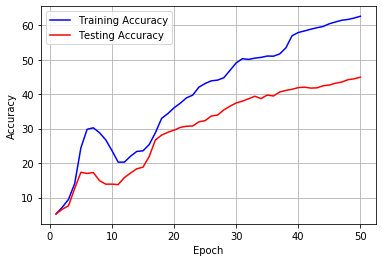

Epoch= 50
Train Acc= 62.613430127041745
Test Acc= 44.93927125506073
Optimizer Learning rate: 0.0000


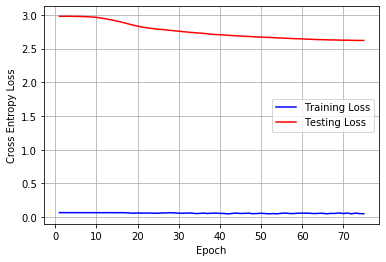

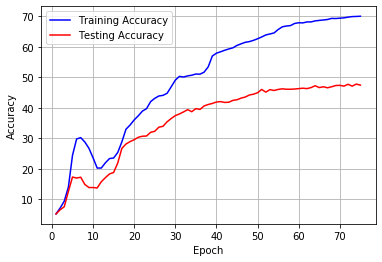

Epoch= 75
Train Acc= 69.98638838475499
Test Acc= 47.43589743589744
Optimizer Learning rate: 0.0000


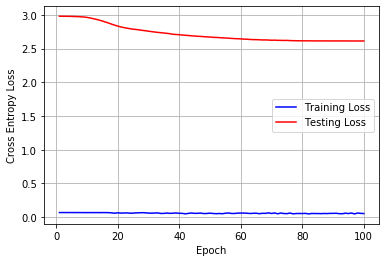

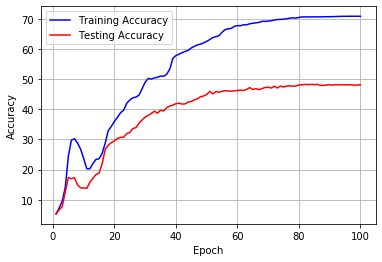

Epoch= 100
Train Acc= 70.93920145190563
Test Acc= 48.178137651821864
Optimizer Learning rate: 0.0000


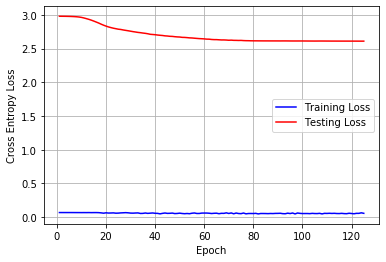

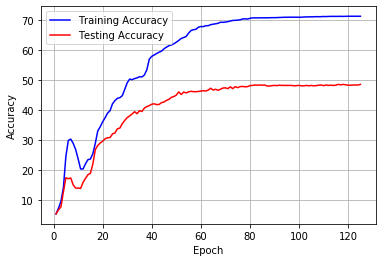

Epoch= 125
Train Acc= 71.27949183303085
Test Acc= 48.51551956815115
Optimizer Learning rate: 0.0000


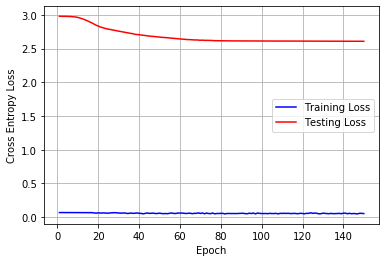

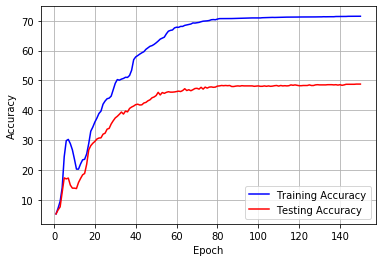

Epoch= 150
Train Acc= 71.52903811252268
Test Acc= 48.78542510121458
Optimizer Learning rate: 0.0000


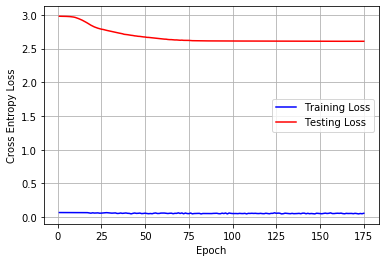

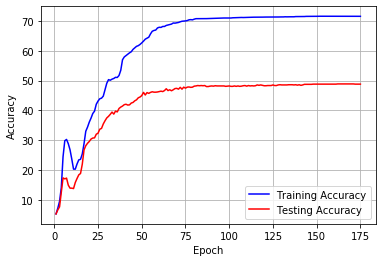

Epoch= 175
Train Acc= 71.52903811252268
Test Acc= 48.78542510121458
Optimizer Learning rate: 0.0000


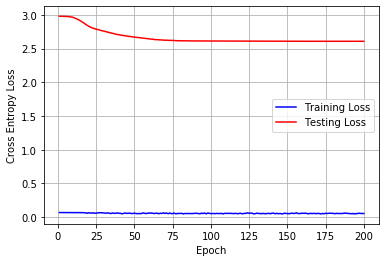

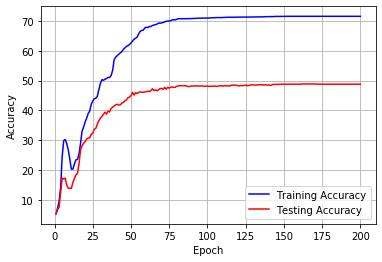

Epoch= 200
Train Acc= 71.55172413793103
Test Acc= 48.78542510121458
Optimizer Learning rate: 0.0000


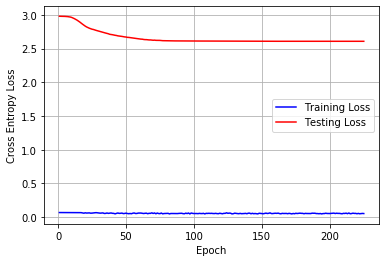

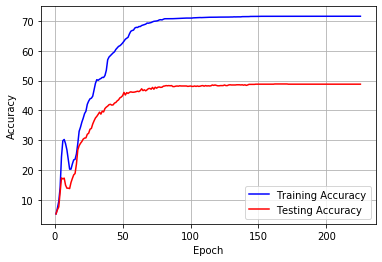

Epoch= 225
Train Acc= 71.57441016333938
Test Acc= 48.78542510121458
Optimizer Learning rate: 0.0000


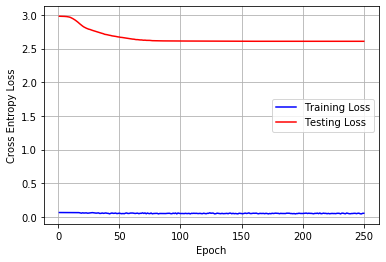

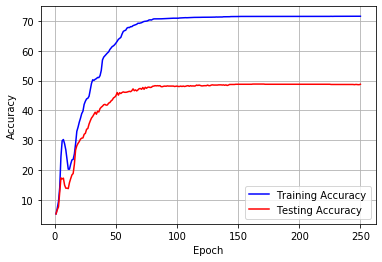

Epoch= 250
Train Acc= 71.61978221415607
Test Acc= 48.78542510121458
Optimizer Learning rate: 0.0000


In [14]:
device = 'cuda'
data_name = 'timit'
optimizer_name = 'SGD'
scheduler_name = 'MultiStepLR'
num_epochs = 250
lr = 0.000001
device = torch.device(device)
in_channels = np.shape(freq_train_set)[1]
out_channels = num_speakers
model = timit_dnn(in_channels,out_channels).to(device)

criterion = nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.00001, betas=(0.98, 0.999), eps=1e-08, weight_decay=0.00001, amsgrad=True)


scheduler = make_scheduler(scheduler_name, optimizer, milestones=[80,150], factor=0.1)

train_loss=[]
test_loss=[]
train_acc=[]
test_acc=[]
for epoch in range(1, num_epochs + 1):
    train_loss_tmp, train_acc_tmp=train(model, device, train_loader[data_name], criterion, optimizer, epoch)
    test_loss_tmp, test_acc_tmp=test(model, device, test_loader[data_name], criterion, epoch)
    
    train_loss.append(train_loss_tmp)
    test_loss.append(test_loss_tmp)
    
    train_acc.append(train_acc_tmp)
    test_acc.append(test_acc_tmp)
    scheduler.step()
    
    if epoch%25==0:
        plt.figure(1)
        plt.plot(np.arange(1,epoch+1),train_loss,color='blue',label='Training Loss')
        plt.plot(np.arange(1,epoch+1),test_loss,color='red',label='Testing Loss')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Cross Entropy Loss')
        plt.grid()
        plt.show()

        plt.figure(2)
        plt.plot(np.arange(1,epoch+1),train_acc,color='blue',label='Training Accuracy')
        plt.plot(np.arange(1,epoch+1),test_acc,color='red',label='Testing Accuracy')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid()
        plt.show()
        
        print('Epoch=',epoch)
        print('Train Acc=',train_acc_tmp)
        print('Test Acc=',test_acc_tmp)
        print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))

